<a href="https://colab.research.google.com/github/axelpuyo/liasd/blob/master/post_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
## Run once
!pip -q install import-ipynb

from google.colab import drive
drive.mount('/content/drive')

import os
print(os.getcwd())
print(os.listdir())

#%cd your_path/Colab Notebooks
%cd drive/MyDrive/Colab Notebooks/liasd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
['.config', 'drive', 'sample_data']
/content/drive/MyDrive/Colab Notebooks/liasd


In [ ]:
import import_ipynb
import utils
import explainers
import colored_mnist

import numpy as np
import random as rd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from explainers.ipynb
importing Jupyter notebook from colored_mnist.ipynb


# Parameters


In [ ]:
## Parameters
# General
tf1 = False # TensorFlow version
explainer = 'cam' # which explainer is to be used: 'cam' = Grad-CAM, 'rise' = RISE, 'shap' = SHAP
model_type = 'rule' # which labels the model was trained on in order to fetch the correct labels

# Noise level
level = 0

In [ ]:
def find_index(target, labels):
  'Returns the positions of the labels which correspond to a target. Ex: find_index(4, train_color) returns the index of all labels = 4 in train_color labels.'
  
  uncategoric_labels = utils.to_uncategoric(labels)
  indexes = np.where(uncategoric_labels == target)[0]
  return indexes

>> checking dataset regularity
label r / counts 425
label 9 / counts 517
label 8 / counts 488
label 7 / counts 580
label 6 / counts 515
label 5 / counts 447
label 4 / counts 547
label 3 / counts 513
label 2 / counts 507
label 1 / counts 560
label 0 / counts 501


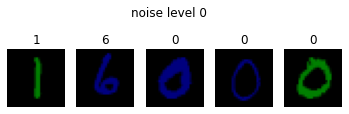

In [ ]:
## Fetch dataset
# Load data
mnist_type = 'noisy'
(train_ims, test_ims, val_ims), (train_color, test_color, val_color), (train_shape, test_shape, val_shape), (train_rule, test_rule, val_rule) = colored_mnist.load_data(8000, mnist_type=mnist_type, noise_level=level, plot=True, regularity_check=True)

# Fetch test_labels and number of unique elements within those labels
if model_type == 'rule':
  num_labels = 11
  test_labels = test_rule
elif model_type == 'shape':
  num_labels = 10
  test_labels = test_shape
else:
  num_labels = 3
  test_labels = test_color

# Deep Explainer Analysis of Feature Maps

In [ ]:
# Deep Explainers
if __name__ == '__main__':
  path = utils.pathfinder(tf1, level, model_type)
  model = keras.models.load_model(path)
  
  if explainer == 'shap': # works great
    # Switch to TensorFlow 1.x behavior (SHAP doesn't work with TF 2.x)
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    # Load model that was trained in TF 1.x. (non-eager mode)
    model = keras.models.load_model(path)

    vals, imgs = explainers.shap(model, test_ims, test_labels, 100, num_labels)

  else:
    # Pick a random image from test set to analyze
    idx = np.random.randint(0, test_labels.shape[0])
    img, lab = test_ims[idx], test_labels[idx]
      
    if explainer == 'cam':
      heatmap, _ = explainers.gradcam(model, 'conv2', img, lab)
      
    elif explainer == 'rise':
      # Parameters : num = number of masks, proba = percentage of occlusion
      num = 500
      proba = 3/4
      heatmap = explainers.rise(model, img, lab, num, proba)
    
    else:
      pass

ValueError: ignored

# Until here

In [ ]:
# This piece of code plots 3 Grad-CAM heatmaps of every unique label in test_labels, next to their original image. 
uncategoric_labels = utils.to_uncategoric(test_labels)

vals, counts = np.unique(uncategoric_labels, return_counts=True)
labels = list(np.flip(vals))

counter = 1
num_reps = 3
plt.figure(figsize=(10*num_labels, num_labels))
while labels:
  for label in np.flip(labels):
    print('Label', label, end='\n')

    reps = 0
    indexes = np.where(uncategoric_labels == label)[0]

    for (num, index) in enumerate(indexes):
      print(f'\r({reps + 1}/{num_reps}) reps - {round(100*num/indexes.shape[0], 1)}%', end='')

      heatmap, acc = explainers.gradcam(model, 'conv2', test_ims[index], test_labels[index], plots=False, verbose=False)
      constant_condition = np.all(heatmap == heatmap[0])
      
      if not constant_condition and acc > 0:
        print(f'\rManaged to compute non-zero heatmap ({reps + 1}/{ num_reps}).', end='')

        # plot image and its heatmap
        plt.subplot(2, 3*len(vals), counter)
        im = test_ims[index] + np.random.rand(test_ims.shape[1], test_ims.shape[2], 3)
        im /= 2
        plt.imshow(im, cmap='hot')
        plt.title('Label {}'.format(utils.uncategoric(test_labels[index])[0]))
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')

        plt.subplot(2, 3*len(vals), 3*len(vals) + counter)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Accuracy {}'.format(acc))
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')

        # update plot numbers
        reps += 1
        counter += 1

        
      # if they're all constant give up and go next  
      else:
        if index == indexes[-1]:
          print('\rAll computed heatmaps were constant.', end='')

          reps += 1
          labels.pop()
          break
      
      # if 3 plots have been drawn for this label, move on to the next label
      if reps == num_reps:
        labels.pop()
        print('')
        break

plt.tight_layout()
plt.show()

In [ ]:
# This piece of code studies the effect of noise_level on the heatmaps returned by Grad-CAM. For a given label, it plots the heatmap of a representative of that label for each noise level in noise_range.
if mnist_type=='noisy':
  label = 5 # label we wish to study
  noise_range = range(1, 10) # range of noise levels to span
  inds = find_index(label, test_labels) # indexes of labels = label in test_labels
  
  compteur = 0
  plt.figure(figsize=(10*num_labels, num_labels))

  for (count, index) in enumerate(inds):
    num = 0
    print('\r>>{}/{}'.format(count+1, len(inds), end=''))

    for level in noise_range:
      # Load corresponding data
      (train_ims, test_ims, val_ims), (train_color, test_color, val_color), (train_shape, test_shape, val_shape), (train_rule, test_rule, val_rule) = colored_mnist.load_data(8000, noise_level=level/10, plot=False, regularity_check=False)
      path = utils.pathfinder(tf1, level/10, model_type)

      if level == 100:
        path = path[:-2] # when noise_level = int, for instance noise_level=1, keras saves them as 'path/to/model/model_name1.0' instead of 'path/to/model/model_name1', thus the two last characters must be removed in order to fetch the correct path.

      model = keras.models.load_model(path) # load corresponding model @path
      heatmap, acc = explainers.gradcam(model, 'conv2', test_ims[index], test_labels[index], plots=False, verbose=False) # compute gradcam heatmap
      constant_condition = np.all(heatmap == heatmap[0]) # checks if the heatmap is constant (thus gradcam failed)

      if not constant_condition and acc > 0:
        compteur += 1

        # plots
        print(f'\rGrad-CAM worked {num}/{len(noise_range)}', end='')
        plt.subplot(1, len(noise_range)+1, compteur+1)
        plt.imshow(heatmap, cmap='jet')
        plt.title(f'Noise Level {level/10}')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')

        num += 1

      else:
        print('\rGrad-CAM failed at Noise Level = {}'.format(level/10), end='')
        compteur = 0
        plt.clf()
        break
      
    print(num)

    # stop condition
    if num == len(noise_range):
      plt.subplot(1, len(noise_range)+1, 1)
      plt.imshow(test_ims[index])
      plt.title('Label {} / Accuracy {}'.format(label, acc))
      plt.colorbar(fraction=0.046, pad=0.04)
      plt.axis('off')
      break

  plt.tight_layout()
  plt.show()

# Hide more stuff

In [ ]:
# # plt.imshow(test_images[inds[0]])
# im = test_ims[1]
# new_im_7_1 = np.zeros(im.shape)
# new_im_7_1[..., 2] = im[..., 0]
# new_im_7_1[..., 1] = im[..., 1]
# label_7_1 = np.zeros(13,)
# label_7_1[12] = 1
# pred = model.predict(new_im_7_1[np.newaxis])[0]
# acc = model.evaluate(new_im_7_1[np.newaxis], label_7_1[np.newaxis])[1]
# print('acc', acc, 'label', pred)

# heatmap = explainers.gradcam(model, 'conv1', new_im_7_1, label_7_1, plots=True)
# # plt.subplot(1, 2, 1)
# # plt.imshow(new_im_7_1)
# # plt.imshow(new_im_7_1)

In [ ]:
# # k = 0
# plt.imshow(test_images[0])
# im_inverse = np.zeros(test_images[1].shape)
# im_inverse[..., 2] = 1 - test_images[1, ..., 0]
# plt.imshow(im_inverse)
# pred = model.predict(im_inverse[np.newaxis])[0]
# acc = model.evaluate(im_inverse[np.newaxis], test_numbers[1][np.newaxis])[1]
# print(pred)

# heatmap = explainers.gradcam(model, 'conv1', im_inverse, test_numbers[1])
# print(test_numbers[1])

In [ ]:
# ## Test number 1 : pass it a colored image without a defined number in it.
# # Image construction
# new_image = np.zeros((1, 28, 28, 3))
# new_image[..., 0] = np.random.rand(28, 28)
# plt.imshow(np.squeeze(new_image))
# plt.show()

# new_label = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

# # Pass it to the model
# accuracy = model.evaluate(new_image, new_label[np.newaxis])[1]
# print('Accuracy : ', accuracy)
# pred = model.predict(new_image)[0]
# print('Predicted label : ', pred)

# ## Test number 2 : pass it a number of a different color than red, green or blue.
# k = 1
# # Image construction
# new_image_2 = np.zeros((1, 28, 28, 3))
# for i in range(3):
#   new_image_2[..., i] = test_images[k, ..., 2]
# plt.imshow(np.squeeze(new_image_2))
# plt.show()

# new_label_2 = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# # Pass it to the model
# accuracy = model.evaluate(new_image_2, new_label_2[np.newaxis])[1]
# print('Accuracy : ', accuracy)
# pred_2 = model.predict(new_image_2)[0]
# print('Predicted label : ', pred_2)

In [ ]:
# def adversarial_tests():
#   red_image = np.random.rand(1,28,28,3)
#   red_image[..., 1] = red_image[..., 2] = 0
#   plt.imshow(np.squeeze(red_image))
#   plt.axis('off')
#   plt.show()

#   pred = model.predict(red_image)[0]
#   pred_bool = (pred == np.max(pred))
#   print(pred, utils.uncategoric(pred_bool)[0])
#   heatmap = explainers.gradcam(model, 'conv1', red_image)
#   # plot gradcam
#   plt.imshow(heatmap, cmap='hot')
#   plt.title('gradcam')
#   plt.show()

#   color_im = np.zeros((1,28,28,3))
#   color_im[0, 0, 0, 1] = 1
#   color_im[0, 0, 1:3, 2] = 1
#   # color_im[0, 5:12, 14:24, 2] = 1
#   # color_im[0, 13:24, 3:14, 2] = 1
#   plt.imshow(np.squeeze(color_im))
#   plt.show()
#   plt.imshow(np.squeeze(color_im[..., 1]), cmap='gray')
#   plt.colorbar()
#   plt.show()

# adversarial_tests()
#   # print('>> Color')
#   # color_model.predict(color_im)
#   # print('>> Shape')
#   # shape_model.predict(color_im)
#   # print('>> Normal')
#   # model.predict(color_im)

#   ## Grad-CAM+SHAP pour voir si ca s'allume autour ou au niveau du chiffre

#   # plt.imshow(np.squeeze(train_images[0]))
#   # plt.axis('off')
#   # plt.show()

#   # new_im = np.zeros((1,28,28,3))
#   # new_im[..., 2] = (1 - train_images[0, ..., 0])
#   # new_im[..., 1] = train_images[0, ..., 0]
#   # plt.imshow(np.squeeze(new_im)[..., 2], cmap='gray')
#   # plt.colorbar()
#   # plt.show()

#   # model.predict(new_im)

In [ ]:
## CONFUSIONS
ims, labels = test_ims, test_rule
labs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'r', 'g', 'b']

n = 200
wrong_list = []
test_ims = ims[:n]
preds = model.predict(test_ims)
for i in range(test_ims.shape[0]):
  pred_max = max(preds[i]) # preds and ground are categorical, we must extract the number corresponding to the max value in the array.
  ground_max = max(labels[i])
  pred_value = list(preds[i]).index(pred_max)
  ground_value = list(labels[i]).index(ground_max)

  if pred_value != ground_value:
    print('predicted value: ', labs[pred_value], '  ground truth: ', labs[ground_value], ' <<')
    wrong_list.append((i, pred_value))
  else:
    print('predicted value: ', labs[pred_value] , '  ground truth: ', labs[ground_value])

In [ ]:
## PLOT WRONG CLASSIFICATIONS
c, plots = 1, 1
print('>> Wrongly classified : ', len(wrong_list), '/', test_ims.shape[0])
plt.suptitle('prediction vs. label', y=0.9)
labs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'red', 'green', 'blue']
for (i, j) in wrong_list:
  ground_truth = list(test_rule[i])
  max_val = max(ground_truth)
  true_label = ground_truth.index(max_val)
  pred_label = labs[j]

  if plots and wrong_list:
    plt.subplot(1, len(wrong_list), c)
    plt.title('{} vs. {}'.format(pred_label, true_label))
    plt.imshow(test_ims[i])
    plt.axis('off')
  c += 1

In [ ]:
## PLOT COLOR CONFUSION PIE CHART
if wrong_list: # THIS IS DEPRECATED
  rgb_confusion = np.zeros((3,))
  for (i, j) in wrong_list: # i : index of wrongly classified image in the test dataset, # j : predicted label of that image.
    im = test_ims[i]
    for k in range(3):
      if im[..., k].any():
        rgb_confusion[k] += 1

  rgb_confusion /= len(wrong_list)
  pie_labels = ['red', 'green', 'blue']
  plt.pie(rgb_confusion, labels = pie_labels, colors = pie_labels, autopct='%1.1f%%')
  plt.title('is misclassification linked to color?')
  plt.show()

In [ ]:
# ## REPRESENTATIONAL SIMILARITY ANALYSIS
# from keras.models import Model

# models = [color_model, shape_model, model]
# model_names = ['Color-biased model', 'Shape-biased model', 'Rule-biased model']
# im = train_images[0]
# if im.ndim < 4:
#   im = np.expand_dims(im, axis=0)

# f_map = [[],[],[]]
# for (n, model) in enumerate(models):
#   print(model_names[n])
#   for i in range(len(model.layers)):
#     if 'conv' not in model.layers[i].name:
#       continue
#     model2 = Model(inputs=model.inputs, outputs=model.layers[i].output)

#     kernels, biases = model.layers[i].get_weights()
#     k_min, k_max = kernels.min(), kernels.max()
#     kernels = (kernels - k_min) / (k_max - k_min)
#     feature_map = model2.predict(im)

#     # f_map = np.squeeze(feature_map[..., 0])
#     # kernel = np.squeeze(kernels[..., 0, 0]) # Ce zéro est suspect, on ne sait pas si ce feature map vient forcément du 1er input du convolutional layer d'avant.

#     # print(model.layers[i].name, kernels.shape)
#     # plt.figure(figsize=(20,5))
#     # plt.subplot(131)
#     # plt.imshow(np.squeeze(im), aspect='auto')
#     # plt.colorbar()
#     # plt.subplot(132)
#     # plt.imshow(kernel, aspect='auto')
#     # plt.colorbar()
#     # plt.subplot(133)
#     # plt.imshow(f_map, aspect='auto')
#     # plt.colorbar()
#     # plt.show()
#     # Visualize all feature maps and corresponding filters.
#     num_maps = feature_map.shape[-1]
#     rows = int(np.floor(np.sqrt(num_maps)))
#     idx = 1
#     # plt.figure(figsize=(20, 10))
#     print(model.layers[i].name, kernels.shape)
#     for j in range(0, num_maps, 8):
#       # print(num_maps, idx, rows*2*rows)
#       f_map[n].append(np.squeeze(feature_map[..., j]))
#       kernel = np.squeeze(kernels[..., 0, j]) # Ce zéro est suspect : revoir les shape des kernels.

#       if n == 2:
#         print(np.array(f_map).shape)
#         print('color_bias : ', np.corrcoef(f_map[0][-1], f_map[2][-1]))
#         print('shape_bias : ', np.corrcoef(f_map[1][-1], f_map[2][-1]))
#       # plt.subplot(2, 8, idx)
#       # plt.imshow(kernel, aspect='auto')
#       # plt.subplot(2, 8, idx + 1)
#       # plt.imshow(f_map, aspect='auto')

#       idx += 2
#     # plt.show()
#   pass # use feature map analysis code developed last week